<a href="https://colab.research.google.com/github/Ken89MathCompSci/ASP.NET-Coding/blob/master/Actual_LTC_Codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ctrnn_layer_1 (CTRNNLayer)           │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0991 - val_loss: 0.0154
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0174 - val_loss: 0.0149
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0176 - val_loss: 0.0135
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0137 - val_loss: 0.0141
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0137 - val_loss: 0.0126
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0137 - val_loss: 0.0156
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0150 - val_loss: 0.0155
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0153 - val_loss: 0.0149
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0159 - val_loss: 0.0133
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0135 - val_loss: 0.0118
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0

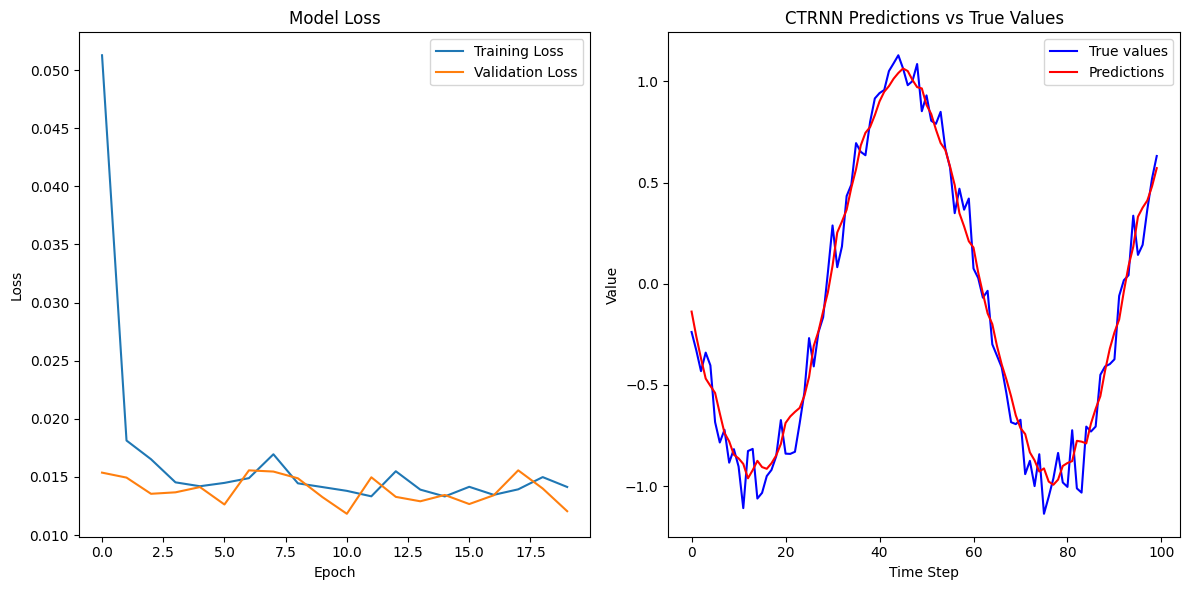

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# For TensorFlow 2.x, the RNNCell is in keras.layers
from tensorflow.keras.layers import Layer, Dense, RNN

# Updated CTRNN class compatible with TensorFlow 2.x as an RNNCell
class CTRNN(Layer):
    def __init__(self, units, cell_clip=-1, global_feedback=False, fix_tau=True, **kwargs):
        super(CTRNN, self).__init__(**kwargs)
        self.units = units
        self._unfolds = 6
        self._delta_t = 0.1
        self.global_feedback = global_feedback
        self.fix_tau = fix_tau
        self.tau = 1.0
        self.cell_clip = cell_clip

        # Add state_size and output_size properties required by Keras RNN
        self.state_size = units
        self.output_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if not self.fix_tau:
            self.tau_var = self.add_weight(
                name='tau',
                shape=[],
                initializer=tf.constant_initializer(self.tau),
                trainable=True
            )

        if not self.global_feedback:
            self.kernel = self.add_weight(
                name='kernel',
                shape=[input_dim, self.units],
                initializer='glorot_uniform',
                trainable=True
            )
            self.bias = self.add_weight(
                name='bias',
                shape=[self.units],
                initializer='zeros',
                trainable=True
            )
        else:
            # Will create these weights during call if needed
            self.kernel = None
            self.bias = None

        if self.global_feedback:
            # For global feedback mode, we'll need weights for combined input+state
            self.feedback_kernel = self.add_weight(
                name='feedback_kernel',
                shape=[input_dim + self.units, self.units],
                initializer='glorot_uniform',
                trainable=True
            )
            self.feedback_bias = self.add_weight(
                name='feedback_bias',
                shape=[self.units],
                initializer='zeros',
                trainable=True
            )

        self.built = True

    def _dense(self, inputs, kernel, bias):
        outputs = tf.matmul(inputs, kernel) + bias
        return tf.nn.tanh(outputs)

    def call(self, inputs, states):
        # In TF2, RNN state comes as a list
        state = states[0]

        # Get tau value
        if not self.fix_tau:
            tau = tf.nn.softplus(self.tau_var)
        else:
            tau = self.tau

        # For non-global feedback, compute input transformation once
        if not self.global_feedback:
            input_f_prime = self._dense(inputs, self.kernel, self.bias)

        # Unfold the ODE solver steps
        for i in range(self._unfolds):
            # For global feedback, compute input+state transformation for each step
            if self.global_feedback:
                fused_input = tf.concat([inputs, state], axis=-1)
                input_f_prime = self._dense(fused_input, self.feedback_kernel, self.feedback_bias)

            # Compute derivative: df/dt
            f_prime = -state/tau + input_f_prime

            # Euler integration step
            state = state + self._delta_t * f_prime

            # Optional clipping
            if self.cell_clip > 0:
                state = tf.clip_by_value(state, -self.cell_clip, self.cell_clip)

        return state, [state]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        else:
            if batch_size is None:
                raise ValueError("If inputs is None, batch_size must be provided")
            if dtype is None:
                dtype = tf.float32

        return [tf.zeros((batch_size, self.units), dtype=dtype)]

    def get_config(self):
        config = super(CTRNN, self).get_config()
        config.update({
            'units': self.units,
            'cell_clip': self.cell_clip,
            'global_feedback': self.global_feedback,
            'fix_tau': self.fix_tau
        })
        return config

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create a simple sine wave dataset for demonstration
def generate_sine_wave_data(samples=1000, sequence_length=50, feature_dim=1):
    """Generate sine wave data for sequence prediction."""
    time = np.arange(0, samples + sequence_length)
    # Generate a sine wave with some noise
    sine_wave = np.sin(0.1 * time) + 0.1 * np.random.randn(len(time))

    # Create input-output pairs (X predicts next Y)
    X = np.zeros((samples, sequence_length, feature_dim))
    y = np.zeros((samples, feature_dim))

    for i in range(samples):
        X[i, :, 0] = sine_wave[i:i+sequence_length]
        y[i, 0] = sine_wave[i+sequence_length]

    # Split into train and test
    train_size = int(0.8 * samples)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, y_train, X_test, y_test

# Generate data
X_train, y_train, X_test, y_test = generate_sine_wave_data(samples=1000, sequence_length=50, feature_dim=1)

# A different approach for TF2 - using a subclass of keras.Layer.RNN directly
class CTRNNLayer(RNN):
    def __init__(self, units, return_sequences=False, return_state=False,
                 cell_clip=-1, global_feedback=False, fix_tau=True, **kwargs):
        self.units = units
        self.cell_clip = cell_clip
        self.global_feedback = global_feedback
        self.fix_tau = fix_tau

        # Create the cell
        cell = CTRNN(units=units, cell_clip=cell_clip,
                    global_feedback=global_feedback, fix_tau=fix_tau)

        # Pass the cell to the RNN parent class
        super(CTRNNLayer, self).__init__(
            cell=cell,
            return_sequences=return_sequences,
            return_state=return_state,
            **kwargs
        )

    def get_config(self):
        config = super(CTRNNLayer, self).get_config()
        config.update({
            'units': self.units,
            'cell_clip': self.cell_clip,
            'global_feedback': self.global_feedback,
            'fix_tau': self.fix_tau
        })
        return config

# Define model parameters
rnn_units = 32
input_shape = (50, 1)  # (sequence_length, features)

# Create a simpler sequential model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    CTRNNLayer(units=rnn_units, global_feedback=True, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse'
)

# Print model summary
model.summary()

# Training parameters
epochs = 20
batch_size = 64

# Convert data to TensorFlow datasets for better performance
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

# Train the model using Keras fit
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset.take(5),
    verbose=1
)

# Evaluate on test set
test_loss = model.evaluate(test_dataset, verbose=0)
print(f"Test MSE: {test_loss:.6f}")

# Make predictions
test_predictions = model.predict(X_test)

# Plot results for visualization
plt.figure(figsize=(12, 6))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot a sample of test predictions vs ground truth
plt.subplot(1, 2, 2)
sample_size = 100
plt.plot(y_test[:sample_size, 0], 'b-', label='True values')
plt.plot(test_predictions[:sample_size, 0], 'r-', label='Predictions')
plt.legend()
plt.title('CTRNN Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')

# Save the plot
plt.tight_layout()
#plt.savefig('ctrnn_predictions.png')
#plt.close()
plt.show()

# Optional: Save model
#model.save_weights('ctrnn_model_weights.weights.h5')
#print("Model training complete and visualization saved!")

# If you want to see predictions more clearly
plt.figure(figsize=(14, 6))
plt.plot(y_test[:200, 0], 'b-', label='True values')
plt.plot(test_predictions[:200, 0], 'r-', label='Predictions')
plt.legend()
plt.title('CTRNN Predictions vs True Values (Extended View)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.savefig('ctrnn_predictions_extended.png')
plt.close()

In [ ]:
# NODE implementation

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

class NODE(tf.keras.layers.Layer):
    def __init__(self, units, time_step=0.1, unfolds=6, cell_clip=-1, **kwargs):
        super(NODE, self).__init__(**kwargs)
        self.units = units
        self.time_step = time_step
        self.unfolds = unfolds
        self.cell_clip = cell_clip
        self.state_size = units  # Define state_size for RNN layer
        self.output_size = units # Define output_size for RNN layer

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim + self.units, self.units),
                                 initializer='glorot_uniform',
                                 name='kernel')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias')
        super(NODE, self).build(input_shape)

    def _dense(self, inputs):
        return tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)

    def _ode_step_runge_kutta(self, inputs, state):
        for _ in range(self.unfolds):
            k1 = self.time_step * self._f_prime(inputs, state)
            k2 = self.time_step * self._f_prime(inputs, state + k1 * 0.5)
            k3 = self.time_step * self._f_prime(inputs, state + k2 * 0.5)
            k4 = self.time_step * self._f_prime(inputs, state + k3)
            state = state + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
            if self.cell_clip > 0:
                state = tf.clip_by_value(state, -self.cell_clip, self.cell_clip)
        return state

    def _f_prime(self, inputs, state):
        # Use TensorFlow control flow instead of Python if statement
        # Get the rank and handle reshaping with tf operations
        rank = tf.rank(inputs)
        # Use tf.cond instead of Python if-else
        inputs = tf.cond(
            rank > 2,
            lambda: tf.squeeze(inputs, axis=1),
            lambda: inputs
        )
        fused_input = tf.concat([inputs, state], axis=-1)
        return self._dense(fused_input)

    def call(self, inputs, state):
        # Ensure state is just a tensor, not a tuple containing a tensor
        if isinstance(state, tuple) and len(state) == 1:
            state = state[0]
        next_state = self._ode_step_runge_kutta(inputs, state)
        return next_state, next_state

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        else:
            # Provide default values if inputs is None
            if batch_size is None:
                batch_size = 1
            if dtype is None:
                dtype = tf.float32
        return tf.zeros((batch_size, self.units), dtype=dtype)

    def get_config(self):
        config = super(NODE, self).get_config()
        config.update({
            'units': self.units,
            'time_step': self.time_step,
            'unfolds': self.unfolds,
            'cell_clip': self.cell_clip
        })
        return config

# Generate sine wave data
def generate_sine_wave_data(samples=1000, sequence_length=50, feature_dim=1):
    time = np.arange(0, samples + sequence_length)
    sine_wave = np.sin(0.1 * time) + 0.1 * np.random.randn(len(time))
    X = np.zeros((samples, sequence_length, feature_dim))
    y = np.zeros((samples, feature_dim))
    for i in range(samples):
        X[i, :, 0] = sine_wave[i:i+sequence_length]
        y[i, 0] = sine_wave[i+sequence_length]
    train_size = int(0.8 * samples)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, y_train, X_test, y_test

# Generate data
X_train, y_train, X_test, y_test = generate_sine_wave_data()

# Define model parameters
rnn_units = 32
input_shape = (50, 1)
feature_length = 1

# Create a Sequential model with the NODE layer
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.RNN(NODE(units=rnn_units), return_sequences=False, stateful=False),
    tf.keras.layers.Dense(feature_length)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Training parameters
epochs = 20
batch_size = 64

# Enable eager execution for debugging if needed
# tf.config.run_functions_eagerly(True)

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

# Make predictions
predictions = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot predictions vs true values
plt.subplot(1, 2, 2)
sample_size = 100
plt.plot(y_test[:sample_size], label='True Values')
plt.plot(predictions[:sample_size], label='Predictions')
plt.title('Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

# Extended view of predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test[:200], label='True Values')
plt.plot(predictions[:200], label='Predictions')
plt.title('Predictions vs True Values (Extended)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_1 (RNN)                     │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
